In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sqlalchemy import text
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
from database.connection import get_db_manager

In [17]:
# CONFIGURACIÓN
TABLE_TYPE = 'domestic'
LEAGUES = [
    'ENG-Premier League',
    'ESP-La Liga', 
    'ITA-Serie A',
    'GER-Bundesliga',
    'FRA-Ligue 1'
]
SEASON = '2425'
MIN_MINUTES = 600

# JUGADORES TARGET
PLAYERS = [
    {'name': 'Georges Mikautadze', 'search': 'Mikautadze', 'pos': 'FW', 'team': 'Lyon', 'colors': ['#0E4C92', '#FFFFFF']}
]

SAVE_PATH_BASE = "../images/mfichajes/"
os.makedirs(SAVE_PATH_BASE, exist_ok=True)

In [18]:
# Conexión BD
db = get_db_manager()

league_list_str = "', '".join(LEAGUES)
query = f"""
SELECT 
    unique_player_id,
    player_name,
    team,
    league,
    season,
    position,
    nationality,
    age,
    fbref_metrics,
    understat_metrics
FROM footballdecoded.players_{TABLE_TYPE} p
WHERE p.league IN ('{league_list_str}')
AND p.season = '{SEASON}'
ORDER BY p.league, p.season DESC, p.team, p.player_name
"""

df_raw = pd.read_sql(query, db.engine)
db.close()

print(f"Extraídos: {df_raw.shape[0]} registros, {df_raw.shape[1]} columnas")
df_raw.head()

2025-09-10 18:05:02,466 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2025-09-10 18:05:02,497 - database.connection - INFO - Database connection successful


Extraídos: 2772 registros, 10 columnas


,unique_player_id,player_name,team,league,season,position,nationality,age,fbref_metrics,understat_metrics
0,4297cac0772af3c8,Ben White,Arsenal,ENG-Premier League,2425,DF,ENG,26.0,"{'CS': '1', 'FK': '0', 'OG': '0', '/90': '-0.0...","{'understat_xa': '1.4500398263335228', 'unders..."
1,258ed61985702bb2,Bukayo Saka,Arsenal,ENG-Premier League,2425,"FW,MF",ENG,22.0,"{'FK': '1', 'OG': '0', 'Crs': '117', 'Fld': '3...","{'understat_xa': '11.583731275051832', 'unders..."
2,57f809b3be3768e0,David Raya,Arsenal,ENG-Premier League,2425,GK,ESP,28.0,"{'CS': '13', 'FK': '0', 'OG': '0', '/90': '0.0...","{'understat_xa': '0.09363602846860886', 'under..."
3,bb58d04ee12cd7fd,Declan Rice,Arsenal,ENG-Premier League,2425,MF,ENG,25.0,"{'FK': '2', 'OG': '0', 'Crs': '164', 'Fld': '1...","{'understat_xa': '9.060594327747822', 'underst..."
4,40384e981d1a5c3c,Ethan Nwaneri,Arsenal,ENG-Premier League,2425,"FW,MF",ENG,17.0,"{'FK': '1', 'OG': '0', 'Crs': '54', 'Fld': '5'...","{'understat_xa': '1.1617773352190852', 'unders..."


In [19]:
# Verificar posiciones disponibles
positions = df_raw['position'].value_counts().sort_index()
print(f"Posiciones: {sorted(df_raw['position'].unique())}")

# Filtrar por minutos mínimos
df_filtered = df_raw[
    df_raw['fbref_metrics'].apply(
        lambda x: x.get('minutes_played', 0) if x else 0
    ) >= MIN_MINUTES
].copy()

print(f"Filtro {MIN_MINUTES}+ min: {df_filtered.shape[0]} jugadores")
df_filtered.head()

Posiciones: ['DF', 'DF,FW', 'DF,MF', 'FW', 'FW,DF', 'FW,MF', 'GK', 'MF', 'MF,DF', 'MF,FW']
Filtro 600+ min: 1811 jugadores


,unique_player_id,player_name,team,league,season,position,nationality,age,fbref_metrics,understat_metrics
0,4297cac0772af3c8,Ben White,Arsenal,ENG-Premier League,2425,DF,ENG,26.0,"{'CS': '1', 'FK': '0', 'OG': '0', '/90': '-0.0...","{'understat_xa': '1.4500398263335228', 'unders..."
1,258ed61985702bb2,Bukayo Saka,Arsenal,ENG-Premier League,2425,"FW,MF",ENG,22.0,"{'FK': '1', 'OG': '0', 'Crs': '117', 'Fld': '3...","{'understat_xa': '11.583731275051832', 'unders..."
2,57f809b3be3768e0,David Raya,Arsenal,ENG-Premier League,2425,GK,ESP,28.0,"{'CS': '13', 'FK': '0', 'OG': '0', '/90': '0.0...","{'understat_xa': '0.09363602846860886', 'under..."
3,bb58d04ee12cd7fd,Declan Rice,Arsenal,ENG-Premier League,2425,MF,ENG,25.0,"{'FK': '2', 'OG': '0', 'Crs': '164', 'Fld': '1...","{'understat_xa': '9.060594327747822', 'underst..."
4,40384e981d1a5c3c,Ethan Nwaneri,Arsenal,ENG-Premier League,2425,"FW,MF",ENG,17.0,"{'FK': '1', 'OG': '0', 'Crs': '54', 'Fld': '5'...","{'understat_xa': '1.1617773352190852', 'unders..."


In [20]:
def extract_metrics(df, col_name):
    result = pd.DataFrame(index=df.index)
    
    all_keys = set()
    for _, row in df.iterrows():
        if isinstance(row[col_name], dict):
            all_keys.update(row[col_name].keys())
    
    for key in all_keys:
        values = []
        for _, row in df.iterrows():
            if isinstance(row[col_name], dict) and key in row[col_name]:
                raw_value = row[col_name][key]
                converted_value = _convert_to_float(raw_value)
                values.append(converted_value)
            else:
                values.append(np.nan)
        
        valid_count = pd.Series(values).notna().sum()
        if valid_count >= 5:
            result[key] = values
    
    return result

def _convert_to_float(value):
    if isinstance(value, (int, float)):
        return float(value)
    
    if value is None or pd.isna(value):
        return np.nan
    
    if isinstance(value, str):
        if value.strip() == '':
            return np.nan
        
        if value.lower().strip() in ['nan', 'none', 'null', '-']:
            return np.nan
        
        try:
            return float(value)
        except (ValueError, TypeError):
            return np.nan
    
    return np.nan

In [21]:
# Extraer métricas numéricas
fbref_nums = extract_metrics(df_filtered, 'fbref_metrics')
understat_nums = extract_metrics(df_filtered, 'understat_metrics')
print(f"FBref: {fbref_nums.shape[1]} métricas | Understat: {understat_nums.shape[1]} métricas")

FBref: 185 métricas | Understat: 10 métricas


In [22]:
# Métricas a excluir de per90
exclude_per90 = {
    'pass_completion_pct', 'shots_on_target_pct', 'Take-Ons_Succ%', 'Take-Ons_Tkld%', 
    'Aerial Duels_Won%', 'Challenges_Tkl%', 'Save%', 'Launched_Cmp%', 'Crosses_Stp%',
    'shots_per_90', 'GA90', 'GCA_GCA90', 'SCA_SCA90', 'Team Success_+/-90', 'SoT/90',
    'npxG/Sh', 'xG+xAG', 'non_penalty_xG_plus_xAG', 'avg_shot_distance', 'minutes_per_match',
    'Passes_AvgLen', 'Goal Kicks_AvgLen', 'Starts_Mn/Start', 'Subs_Mn/Sub', 'Min%',
    'matches_played', 'matches_started', 'minutes_played', 'wins', 'draws', 'losses',
    'understat_buildup_involvement_pct', 'understat_player_id', 'understat_team_id'
}

# Calcular per90 FBref
fbref_per90 = fbref_nums.loc[:, ~fbref_nums.columns.isin(exclude_per90)]
fbref_per90 = (fbref_per90.div(fbref_nums['minutes_played'], axis=0) * 90).round(3)
fbref_per90.columns = [f'{col}_per90' for col in fbref_per90.columns]

# Calcular per90 Understat
understat_per90 = understat_nums.loc[:, ~understat_nums.columns.isin(exclude_per90)]
understat_per90 = (understat_per90.div(fbref_nums['minutes_played'], axis=0) * 90).round(3)
understat_per90.columns = [f'{col}_per90' for col in understat_per90.columns]

print(f"Per90: {fbref_per90.shape[1]} + {understat_per90.shape[1]}")

# COMBINAR todas las métricas
all_metrics = pd.concat([fbref_nums, understat_nums, fbref_per90, understat_per90], axis=1)

Per90: 154 + 7


In [23]:
# Calcular percentiles
all_percentiles = all_metrics.rank(pct=True) * 98 + 1
all_percentiles = all_percentiles.round(0).astype('Int64')
all_percentiles.columns = [f'{col}_pct' for col in all_percentiles.columns]

print(f"Métricas totales: {all_metrics.shape[1]}")
print(f"Percentiles totales: {all_percentiles.shape[1]}")

Métricas totales: 356
Percentiles totales: 356


In [24]:
# DataFrame final consolidado
base_cols = ['unique_player_id', 'player_name', 'team', 'league', 'season', 'position']

df_final = pd.concat([
    df_filtered[base_cols],
    all_metrics,
    all_percentiles
], axis=1)

print(f"DataFrame final: {df_final.shape[0]} filas, {df_final.shape[1]} columnas")

# Limpieza de Series anidados
def clean_series_values(df):
    for col in df.columns:
        series_mask = df[col].apply(lambda x: isinstance(x, pd.Series))
        
        if series_mask.any():
            print(f"Limpiando Series en: {col}")
            df[col] = df[col].apply(
                lambda x: x.iloc[0] if isinstance(x, pd.Series) and not x.empty else x
            )
    return df

df_final = clean_series_values(df_final)

# Eliminar columnas problemáticas
problem_cols = ['shots_on_target_pct']
df_final = df_final.drop(columns=[col for col in problem_cols if col in df_final.columns])

print(f"Limpieza completada: {df_final.shape[1]} columnas finales")

DataFrame final: 1811 filas, 718 columnas
Limpiando Series en: shots_on_target_pct
Limpiando Series en: shots_on_target_pct
Limpieza completada: 716 columnas finales


In [25]:
# EXPLORACIÓN MÉTRICAS DISPONIBLES
print("MÉTRICAS FBREF DISPONIBLES:")
print("=" * 50)
fbref_sorted = sorted(list(fbref_nums.columns))
for i, metric in enumerate(fbref_sorted, 1):
    print(f"{i:2d}. {metric}")

print(f"\nTotal FBref: {len(fbref_sorted)}")

print("\nMÉTRICAS UNDERSTAT DISPONIBLES:")
print("=" * 50)
understat_sorted = sorted(list(understat_nums.columns))
for i, metric in enumerate(understat_sorted, 1):
    print(f"{i:2d}. {metric}")

print(f"\nTotal Understat: {len(understat_sorted)}")

print("\nMÉTRICAS PER90 DISPONIBLES:")
print("=" * 50)
per90_sorted = sorted([col for col in all_metrics.columns if col.endswith('_per90')])
for i, metric in enumerate(per90_sorted[:20], 1):
    print(f"{i:2d}. {metric}")
if len(per90_sorted) > 20:
    print(f"... y {len(per90_sorted) - 20} más")

print(f"\nTotal Per90: {len(per90_sorted)}")

MÉTRICAS FBREF DISPONIBLES:
 1. /90
 2. 2CrdY
 3. A-xAG
 4. Aerial Duels_Lost
 5. Aerial Duels_Won
 6. Aerial Duels_Won%
 7. Blocks_Blocks
 8. Blocks_Pass
 9. Blocks_Sh
10. CS
11. CS%
12. Carries_1/3
13. Carries_CPA
14. Carries_Carries
15. Carries_Dis
16. Carries_Mis
17. Carries_PrgC
18. Carries_PrgDist
19. Carries_TotDist
20. Challenges_Att
21. Challenges_Lost
22. Challenges_Tkl
23. Challenges_Tkl%
24. Corner Kicks_In
25. Corner Kicks_Out
26. Corner Kicks_Str
27. Crosses_Opp
28. Crosses_Stp
29. Crosses_Stp%
30. Crs
31. CrsPA
32. FK
33. Fld
34. Fls
35. G+A-PK
36. G-xG
37. GA90
38. GCA Types_Def
39. GCA Types_Fld
40. GCA Types_PassDead
41. GCA Types_PassLive
42. GCA Types_Sh
43. GCA Types_TO
44. GCA_GCA
45. GCA_GCA90
46. Goal Kicks_Att
47. Goal Kicks_AvgLen
48. Goal Kicks_Launch%
49. Goals_CK
50. Goals_FK
51. Goals_GA
52. Goals_OG
53. Goals_PKA
54. Launched_Att
55. Launched_Cmp
56. Launched_Cmp%
57. Min%
58. OG
59. Off
60. Outcomes_Blocks
61. Outcomes_Cmp
62. Outcomes_Off
63. PKcon
64. 

In [26]:
# Buscar jugadores - AÑADIDO YEREMY PINO
players_to_search = [
    {'name': 'Georges Mikautadze', 'search': 'Mikautadze'},
    {'name': 'Yeremi Pino', 'search': 'Pino'}
]

player_ids = {}

for player in players_to_search:
    search_results = df_filtered[
        df_filtered['player_name'].str.contains(player['search'], case=False, na=False)
    ]
    
    print(f"\n{player['name']} (búsqueda: '{player['search']}'):")
    if len(search_results) > 0:
        for _, p in search_results.iterrows():
            print(f"  {p['unique_player_id']} - {p['player_name']} ({p['team']}, {p['league']}, {p['position']})")
            
            if player['name'] not in player_ids:
                player_ids[player['name']] = p['unique_player_id']
    else:
        print(f"  No encontrado")

print(f"\nJugadores encontrados: {len(player_ids)}/{len(players_to_search)}")


Georges Mikautadze (búsqueda: 'Mikautadze'):
  a8fe4e1b129cf192 - Georges Mikautadze (Lyon, FRA-Ligue 1, FW)

Yeremi Pino (búsqueda: 'Pino'):
  aa9083311b3666d1 - Alfonso Espino (Rayo Vallecano, ESP-La Liga, DF)
  f096ea6851899e57 - Yeremi Pino (Villarreal, ESP-La Liga, MF,FW)

Jugadores encontrados: 2/2


In [27]:
# Configurar IDs de ambos jugadores
MIKA_ID = "a8fe4e1b129cf192"  # Georges Mikautadze
YEREMI_ID = "f096ea6851899e57"  # Se actualizará después de ejecutar la búsqueda

In [28]:
'''
DELANTERO CENTRO (10 métricas) - LISTA DEFINITIVA:

1. expected_goals
2. goals
3. shots
4. Touches_Att Pen
5. expected_assists
6. Take-Ons_Succ
7. npxG/Sh
8. G-xG
9. Fld
10. shot creating actions

Analizando el radar de extremo que muestras y siguiendo la misma lógica, para **EXTREMO** seleccionaría estas 10 métricas:

EXTREMO (10 métricas) - LISTA DEFINITIVA:

1. expected_goals
2. shots  
3. expected_assists
4. Take-Ons_Succ
5. Touches_Att Pen
6. SCA_SCA90
7. Crs
8. Carries_PrgC
9. npxG/Sh
10. Fld

DEFENSA CENTRAL (10 métricas) - LISTA DEFINITIVA:

1. pass_completion_pct
2. Challenges_Tkl%
3. Aerial Duels_Won
4. Aerial Duels_Won%
5. Launched_Cmp
6. clearances
7. progressive_passes
8. Tkl+Int
9. interceptions
10. Blocks_Sh

LATERAL (10 métricas) - LISTA DEFINITIVA:

1. pass_completion_pct
2. progressive_passes
3. Carries_PrgC
4. Crs
5. passes_penalty_area
6. expected_assists
7. Touches_Att 3rd
8. Tkl+Int
9. Challenges_Tkl%
10. Take-Ons_Succ

MEDIOCENTRO (10 métricas) - LISTA DEFINITIVA EN ORDEN COHERENTE:

1. progressive_passes
2. Carries_PrgC
3. SCA_SCA90
4. expected_assists
5. passes_penalty_area
6. Take-Ons_Succ
7. Tkl+Int
8. interceptions
9. Fld
10. pass_completion_pct

PIVOTE (10 métricas) - LISTA DEFINITIVA:

1. pass_completion_pct
2. progressive_passes
3. Tkl+Int
4. interceptions
5. Challenges_Tkl%
6. Carries_PrgC
7. SCA_SCA90
8. Recov
9. Fld
10. expected_assists

PORTERO (10 métricas) - LISTA DEFINITIVA:

1. Save%
2. PSxG+/-
3. CS%
4. GA90
5. pass_completion_pct
6. Launched_Cmp%
7. Goal Kicks_Launch%
8. Sweeper_#OPA/90
9. Sweeper_AvgDist
10. SoT/90
'''

'\nDELANTERO CENTRO (10 métricas) - LISTA DEFINITIVA:\n\n1. expected_goals\n2. goals\n3. shots\n4. Touches_Att Pen\n5. expected_assists\n6. Take-Ons_Succ\n7. npxG/Sh\n8. G-xG\n9. Fld\n10. shot creating actions\n\nAnalizando el radar de extremo que muestras y siguiendo la misma lógica, para **EXTREMO** seleccionaría estas 10 métricas:\n\nEXTREMO (10 métricas) - LISTA DEFINITIVA:\n\n1. expected_goals\n2. shots  \n3. expected_assists\n4. Take-Ons_Succ\n5. Touches_Att Pen\n6. SCA_SCA90\n7. Crs\n8. Carries_PrgC\n9. npxG/Sh\n10. Fld\n\nDEFENSA CENTRAL (10 métricas) - LISTA DEFINITIVA:\n\n1. pass_completion_pct\n2. Challenges_Tkl%\n3. Aerial Duels_Won\n4. Aerial Duels_Won%\n5. Launched_Cmp\n6. clearances\n7. progressive_passes\n8. Tkl+Int\n9. interceptions\n10. Blocks_Sh\n\nLATERAL (10 métricas) - LISTA DEFINITIVA:\n\n1. pass_completion_pct\n2. progressive_passes\n3. Carries_PrgC\n4. Crs\n5. passes_penalty_area\n6. expected_assists\n7. Touches_Att 3rd\n8. Tkl+Int\n9. Challenges_Tkl%\n10. Take

In [29]:
# Position metrics configuration
gk_metrics = [
    'Save%', 'PSxG+/-', 'CS%', 'GA90', 'pass_completion_pct',
    'Launched_Cmp%', 'Goal Kicks_Launch%', 'Sweeper_#OPA/90', 'Sweeper_AvgDist', 'SoT/90'
]

gk_titles = [
    'Save %', 'PSxG +/-', 'Clean Sheets %', 'Goals Against', 'Pass Accuracy %',
    'Long Pass %', 'Long Kicks %', 'Sweeper Actions', 'Sweeper Distance', 'Shots Faced /90'
]

df_metrics = [
    'pass_completion_pct', 'Challenges_Tkl%', 'Aerial Duels_Won_per90', 'Aerial Duels_Won%',
    'passes_final_third_per90', 'clearances_per90', 'progressive_passes_per90', 'Tkl+Int_per90',
    'interceptions_per90', 'Blocks_Sh_per90'
]
df_titles = [
    'Pass Accuracy %', 'Tackle Success %', 'Aerial Duels Won', 'Aerial Success %',
    'Final Third Passes', 'Clearances', 'Progressive Passes', 'Tackles + Interceptions',
    'Interceptions', 'Shot Blocks'
]

lateral_metrics = [
    'pass_completion_pct', 'progressive_passes_per90', 'Carries_PrgC_per90', 'Crs_per90',
    'passes_penalty_area_per90', 'expected_assists_per90', 'Touches_Att 3rd_per90', 
    'Tkl+Int_per90', 'Challenges_Tkl%', 'Take-Ons_Succ_per90'
]
lateral_titles = [
    'Pass Accuracy %', 'Progressive Passes', 'Progressive Carries', 'Crosses',
    'Box Passes', 'Expected Assists', 'Touches Final Third', 
    'Tackles + Interceptions', 'Tackle Success %', 'Dribbles'
]

mf_metrics = [
    'progressive_passes_per90', 'Carries_PrgC_per90', 'SCA_SCA90', 'expected_assists_per90',
    'passes_penalty_area_per90', 'Take-Ons_Succ_per90', 'Tkl+Int_per90', 'interceptions_per90',
    'Fld_per90', 'pass_completion_pct'
]
mf_titles = [
    'Progressive Passes', 'Progressive Carries', 'Shot Creating Actions', 'Expected Assists',
    'Box Passes', 'Dribbles', 'Tackles + Interceptions', 'Interceptions',
    'Fouls Drawn', 'Pass Accuracy %'
]

pivote_metrics = [
    'pass_completion_pct', 'progressive_passes_per90', 'Tkl+Int_per90', 'interceptions_per90',
    'Challenges_Tkl%', 'Carries_PrgC_per90', 'SCA_SCA90', 'Recov_per90',
    'Fld_per90', 'expected_assists_per90'
]
pivote_titles = [
    'Pass Accuracy %', 'Progressive Passes', 'Tackles + Interceptions', 'Interceptions',
    'Tackle Success %', 'Progressive Carries', 'Shot Creating Actions', 'Recoveries',
    'Fouls Drawn', 'Expected Assists'
]

extremo_metrics = [
    'expected_goals_per90', 'shots_per90', 'expected_assists_per90', 'Take-Ons_Succ_per90',
    'Touches_Att Pen_per90', 'SCA_SCA90', 'Crs_per90', 'Carries_PrgC_per90',
    'npxG/Sh', 'Fld_per90'
]
extremo_titles = [
    'Expected Goals', 'Shots', 'Expected Assists', 'Dribbles',
    'Touches in Box', 'Shot Creating Actions', 'Crosses', 'Progressive Carries',
    'npxG per Shot', 'Fouls Drawn'
]

fw_metrics = [
    'expected_goals_per90', 'goals_per90', 'shots_per90', 'Touches_Att Pen_per90',
    'expected_assists_per90', 'Take-Ons_Succ_per90', 'npxG/Sh', 'G-xG_per90',
    'Fld_per90', 'SCA_SCA90'
]
fw_titles = [
    'Expected Goals', 'Goals', 'Shots', 'Touches in Box',
    'Expected Assists', 'Dribbles', 'npxG per Shot', 'Goals - xG',
    'Fouls Drawn', 'Shot Creating Actions'
]

configs = [
    ('GK', gk_metrics, gk_titles),
    ('DF Central', df_metrics, df_titles),
    ('DF Lateral', lateral_metrics, lateral_titles),
    ('MF', mf_metrics, mf_titles),
    ('MF Pivote', pivote_metrics, pivote_titles),
    ('FW Extremo', extremo_metrics, extremo_titles),
    ('FW Centro', fw_metrics, fw_titles)
]

print("POSITION METRICS VERIFICATION:")
print("=" * 50)
for pos, metrics, titles in configs:
    status = "OK" if len(metrics) == 10 and len(titles) == 10 else "ERROR"
    print(f"{status} {pos}: {len(metrics)} metrics, {len(titles)} titles")

print(f"\nTOTAL POSITIONS: {len(configs)}")

POSITION METRICS VERIFICATION:
OK GK: 10 metrics, 10 titles
OK DF Central: 10 metrics, 10 titles
OK DF Lateral: 10 metrics, 10 titles
OK MF: 10 metrics, 10 titles
OK MF Pivote: 10 metrics, 10 titles
OK FW Extremo: 10 metrics, 10 titles
OK FW Centro: 10 metrics, 10 titles

TOTAL POSITIONS: 7


Generando radar + tabla comparativa Mikautadze vs Yeremi Pino...
Dataset: 589 jugadores FW
✓ Radar comparativo completado
DEBUG Player 1 - Team: 'Lyon', team_logos keys: ['Lyon', 'Villarreal']
DEBUG P1 - Loading logo from: ../caras/villareal/Mikautadze.png
DEBUG P1 - Logo loaded successfully for Lyon
DEBUG Player 2 - Team: 'Villarreal', team_logos keys: ['Lyon', 'Villarreal']
DEBUG P2 - Loading logo from: ../caras/españa/Yeremi.png
DEBUG P2 - Logo loaded successfully for Villarreal
✓ Tabla comparativa completada
✓ Imagen combinada completada


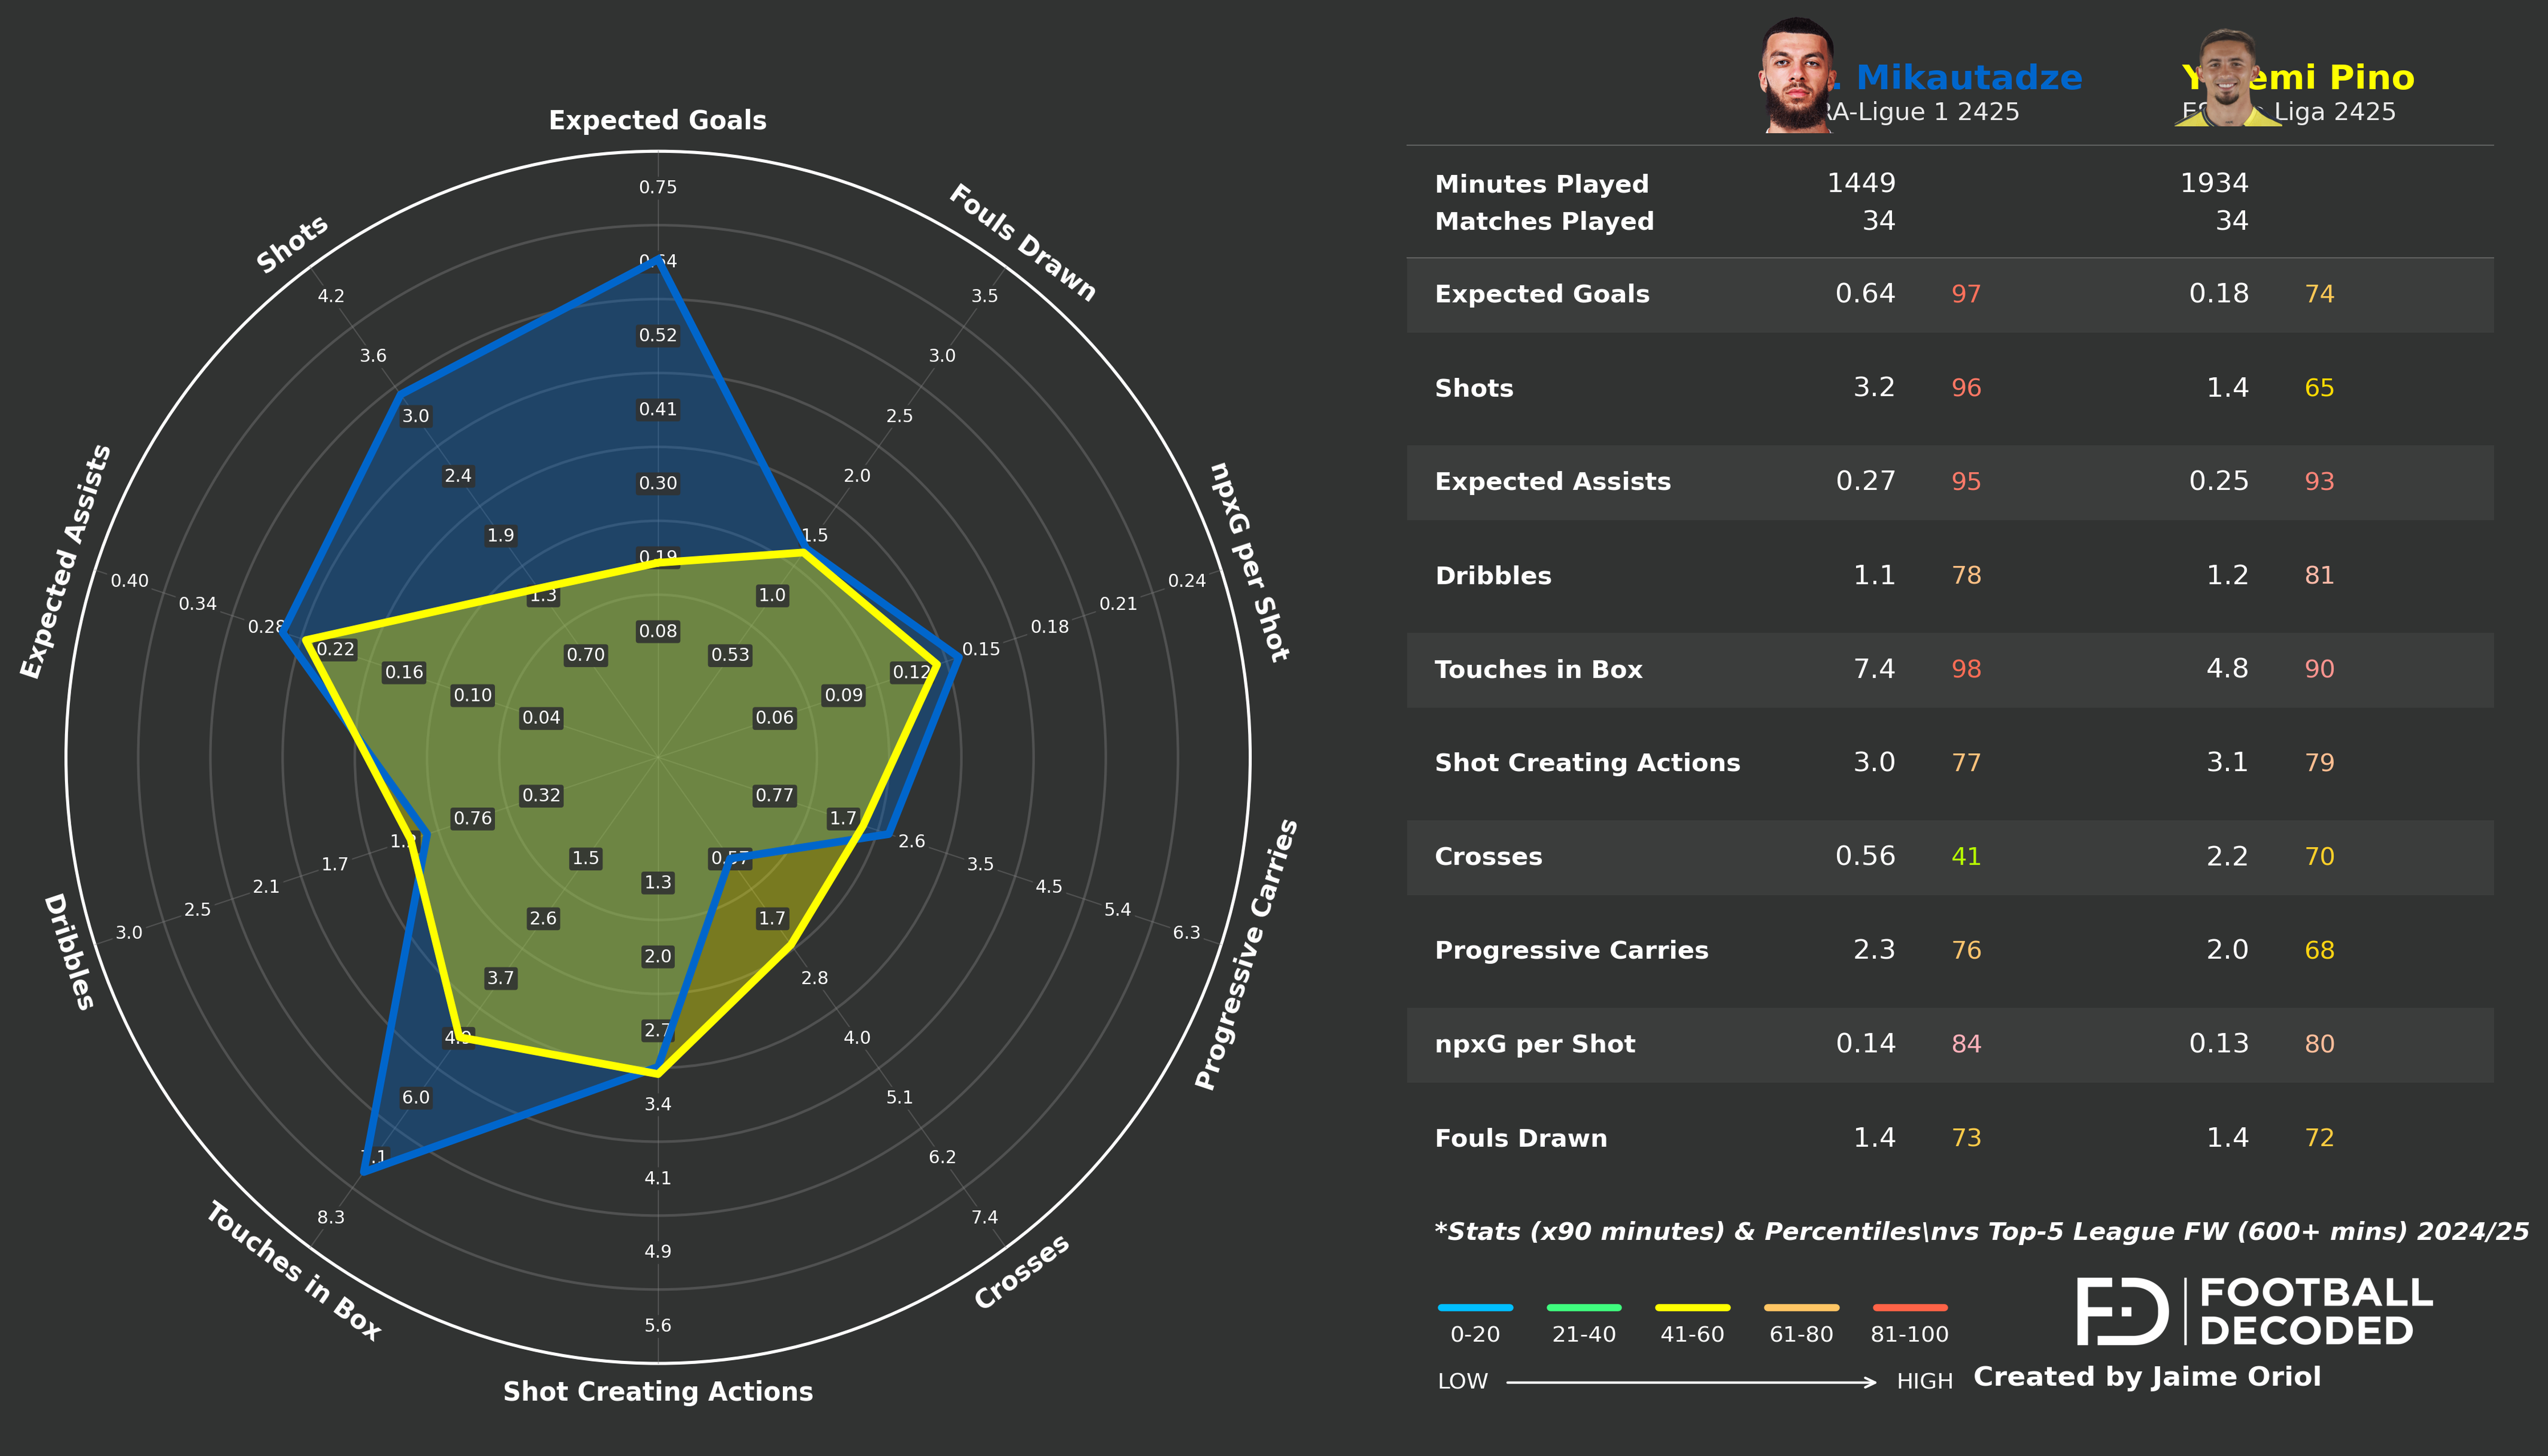

In [ ]:
from viz.swarm_radar import create_player_radar
from viz.stats_radar import create_stats_table, combine_radar_and_table
from IPython.display import Image as IPImage, display

if MIKA_ID and YEREMI_ID:
    # Filtrar dataset por posición FW (ambos son delanteros/extremos)
    position_df = df_final[df_final['position'].str.contains('FW')].copy()
    
    print(f"Generando radar + tabla comparativa Mikautadze vs Yeremi Pino...")
    print(f"Dataset: {position_df.shape[0]} jugadores FW")
    
    # Métricas para extremos/delanteros
    metrics = extremo_metrics
    titles = extremo_titles
    
    try:
        # 1. RADAR COMPARATIVO
        create_player_radar(
            df_data=position_df,
            player_1_id=MIKA_ID,
            player_2_id=YEREMI_ID,
            metrics=metrics,
            metric_titles=titles,
            team_colors=['#0066CC', '#FFFF00'],  # Lyon azul, Villarreal amarillo
            save_path=f"{SAVE_PATH_BASE}Mikautadze_vs_Yeremi_comparative_radar.png",
            use_swarm=False,
            show_plot=False
        )
        
        # 2. TABLA COMPARATIVA
        create_stats_table(
            df_data=position_df,
            player_1_id=MIKA_ID,
            player_2_id=YEREMI_ID,
            metrics=metrics,
            metric_titles=titles,
            team_colors=['#0066CC', '#FFFF00'],  # Lyon azul, Villarreal amarillo
            save_path=f"{SAVE_PATH_BASE}Mikautadze_vs_Yeremi_comparative_table.png",
            team_logos={"Lyon": "../caras/villareal/Mikautadze.png", "Villarreal": "../caras/españa/Yeremi.png"},
            footer_text="Stats (x90 minutes) & Percentiles\\nvs Top-5 League FW (600+ mins) 2024/25",
            show_plot=False
        )
        
        # 3. COMBINAR RADAR + TABLA
        combine_radar_and_table(
            radar_path=f"{SAVE_PATH_BASE}Mikautadze_vs_Yeremi_comparative_radar.png",
            table_path=f"{SAVE_PATH_BASE}Mikautadze_vs_Yeremi_comparative_table.png",
            output_path=f"{SAVE_PATH_BASE}Mikautadze_vs_Yeremi_COMBINED.png"
        )
        print("✓ Imagen combinada completada")
        
        display(IPImage(f"{SAVE_PATH_BASE}Mikautadze_vs_Yeremi_COMBINED.png"))
        
    except Exception as e:
        print(f"✗ Error generando visualizaciones: {str(e)}")
        import traceback
        traceback.print_exc()
        
else:
    print("No se pueden generar los radares - faltan IDs de jugadores")
    print(f"MIKA_ID: {MIKA_ID}")
    print(f"YEREMI_ID: {YEREMI_ID}")